In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
train_file = open("./Full-labels-2.txt")
lines = train_file.readlines()
train_file.close()

filenames = []
labels = []

for line in lines:
    filenames.append('Celeb-DF-Image-Face-Crop-SRM/'+line[2:].rstrip('\n'))    
for l in lines:
    labels.append(l[:1])

labels = [int(i) for i in labels]

train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, train_size=0.85, random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)

In [3]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels)))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels)))

In [4]:
#  function that can load the images from file and perform any necessary preprocessing.

IMAGE_SIZE = 128
BATCH_SIZE = 32

def _parse_fn(img, label):
    img_string = tf.io.read_file(img)
    img_decoded = tf.image.decode_jpeg(img_string)
    img_normalized = (tf.cast(img_decoded, tf.float32)/127.5) - 1
    img_resized = tf.image.resize(img_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    #img_preprocess = tf.keras.applications.resnet_v2.preprocess_input(img_resized)
    return img_resized, label

train_data = (train_data.map(_parse_fn).shuffle(buffer_size=1000).batch(BATCH_SIZE))
val_data = (val_data.map(_parse_fn).shuffle(buffer_size=1000).batch(BATCH_SIZE))

In [5]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.ResNet50V2(
    include_top=False, weights="imagenet",
    input_shape=IMG_SHAPE, pooling="max", classes=2,
    classifier_activation="relu"
)

In [6]:
base_model.trainable = False

In [7]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    base_model,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [9]:
epochs = 40
steps_per_epoch = 100
val_steps = 20


history = model.fit(train_data.repeat(),
                      epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      validation_data = val_data.repeat(), 
                      validation_steps = val_steps)

Epoch 1/40
100/100 [==============================] - 50s 496ms/step - loss: 0.6488 - accuracy: 0.6559 - val_loss: 0.4579 - val_accuracy: 0.8516
Epoch 2/40
100/100 [==============================] - 49s 489ms/step - loss: 0.4462 - accuracy: 0.8579 - val_loss: 0.4283 - val_accuracy: 0.8687
Epoch 3/40
100/100 [==============================] - 48s 478ms/step - loss: 0.4042 - accuracy: 0.8734 - val_loss: 0.4270 - val_accuracy: 0.8625
Epoch 4/40
100/100 [==============================] - 49s 490ms/step - loss: 0.4132 - accuracy: 0.8655 - val_loss: 0.4164 - val_accuracy: 0.8687
Epoch 5/40
100/100 [==============================] - 50s 498ms/step - loss: 0.4206 - accuracy: 0.8607 - val_loss: 0.4235 - val_accuracy: 0.8594
Epoch 6/40
100/100 [==============================] - 50s 505ms/step - loss: 0.3875 - accuracy: 0.8731 - val_loss: 0.3957 - val_accuracy: 0.8734
Epoch 7/40
100/100 [==============================] - 49s 494ms/step - loss: 0.3955 - accuracy: 0.8670 - val_loss: 0.3984 - val_ac

In [10]:
model.save_weights('./ResNet-Weights/weights_epoch_30.h5')

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

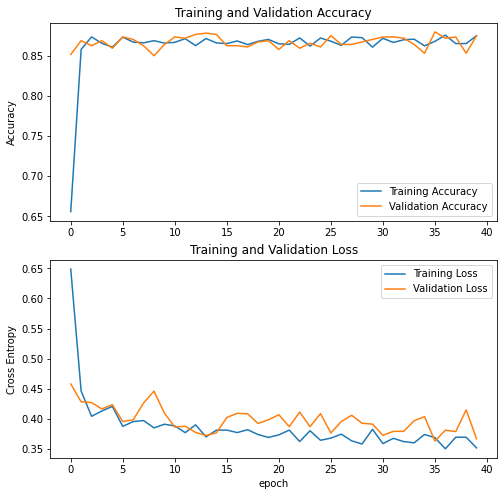

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
pred = model.predict(val_data, verbose=1)

28/28 [==============================] - 10s 357ms/step


In [14]:
model.evaluate(val_data)

28/28 [==============================] - 10s 358ms/step - loss: 0.3855 - accuracy: 0.8680


[0.3854508101940155, 0.8679678440093994]

In [15]:
from sklearn.metrics import roc_auc_score
y_true = np.array(val_labels)
y_scores = pred
roc_auc_score(y_true, y_scores)

0.5485498972368121

[[755   0]
 [116   0]]



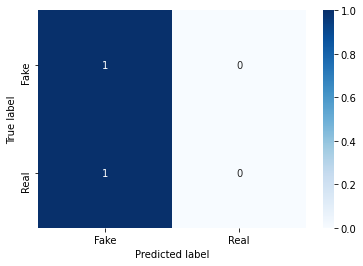

In [16]:
tf.math.confusion_matrix(y_true, y_scores)

classes=["Fake", "Real"]

con_mat = tf.math.confusion_matrix(labels=y_true.ravel(), predictions=y_scores.ravel(), num_classes=2).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat)
print("")
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

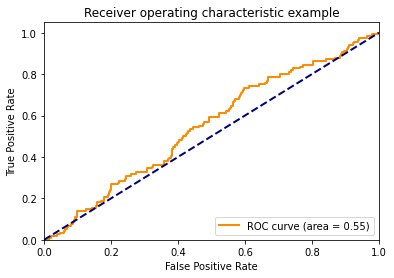

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=None)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
report = metrics.classification_report(y_true,np.round(y_scores),labels=[1,0])
print(report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       116
           0       0.87      1.00      0.93       755

    accuracy                           0.86       871
   macro avg       0.43      0.50      0.46       871
weighted avg       0.75      0.86      0.80       871

